# CSC 620 -- HA #10

By: Mark Kim

Adapted from
[dbaghern](https://www.kaggle.com/code/baghern/a-deep-dive-into-sklearn-pipelines/notebook)

This assignment extends from assignment #9 -- I apologize...this notebook is a mess.  In this assignment, we will be
doing the following:
1. Extend your HW#9 program to do:

    - [CV: Experiment with 3 cross-validation (CV) settings: 2-fold, 10-fold, and 20-fold.](#1a-cross-validation)

    - [Feature importance analysis / Model interpretation:  For each class, print the 10 most important features, and the 10 least important features.  Also, print the weights learnt for the three features you added in HW#9.](#1b-most-important-features-and-weights-for-features-added)   

    - [Error analysis: For test set, print 10 data-points for which the model prediction is wrong.  Print the feature vectors, predicted class label, and ground truth class label for each of these data-points. (This analysis will be easiest to do with fixed train/test split; that is; without CV.)](#1c-error-analysis)

2. Write a report (2-pager) on this experiment that (REPORT ATTACHED):

    - CV: Compare and contrast model performance across the three CV settings. 

    - Feature importance analysis / Model interpretation: Specifies 3 most important features and 3 least important features for each class.  For each feature, describe your conjecture for why that weights was learnt for that feature. 

    - Error analysis: Compare and contrast the 10 data-points.  Report at least 3 trends/patterns that you observe. (E.g. (1) Majority of the errors are on data-points with ground truth label of Class X.  (2) Feature Y is high-weight feature for Class Z and low-weight for Class X, which may be the cause for class being predicted as Z instead of X.)
    Submit (1) your notebook or Python program, and (2) your report to ilearn. 

Below, we import the libraries we need and read in our training data.  This data
consists of sentences from horror stories and their authors.  The purpose of this notebook is
to predict the author of a horror story sentence given its text.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import dill

In [2]:
df = pd.read_csv('./input/train.csv')

df.dropna(axis=0)
df.set_index('id', inplace = True)

df.head()

,text,author
id,,
id26305,"This process, however, afforded me no means of...",EAP
id17569,It never once occurred to me that the fumbling...,HPL
id11008,"In his left hand was a gold snuff box, from wh...",EAP
id27763,How lovely is spring As we looked from Windsor...,MWS
id12958,"Finding nothing else, not even gold, the Super...",HPL


## Preprocessing and Feature Engineering

The function in this next cell does a little bit of text normalization 
(removal of punctuation and capitalization), then does some feature engineering.

The feature engineering of the original author consists of the following:
1. Number of characters in the sentence/text.
2. Number of words in the sentence/text (minus stopwords).
3. Average word length of words in sentence/text (minus stopwords).
4. Number of commas used in a sentence/text.

Starting on line 26 of the code below, I have implemented the three additional
features required by the assignment:
1. Number of Adjectives.
2. Number of Nouns.
3. Number of Verbs.

In [3]:
stopWords = set(stopwords.words('english'))

#creating a function to encapsulate preprocessing, to mkae it easy to replicate on  submission data
def processing(df):
    #lowering and removing punctuation
    df['processed'] = df['text'].apply(lambda x: re.sub(r'[^\w\s]','', x.lower()))
    
    #numerical feature engineering
    #total length of sentence
    df['length'] = df['processed'].apply(lambda x: len(x))
    #get number of words
    df['words'] = df['processed'].apply(lambda x: len(x.split(' ')))
    df['words_not_stopword'] = df['processed'].apply(
        lambda x: len([t for t in x.split(' ') if t not in stopWords]))
    #get the average word length
    df['avg_word_length'] = df['processed'].apply(
        lambda x: np.mean([len(t) for t in x.split(' ') if t not in stopWords]) 
            if len([len(t) for t in x.split(' ') if t not in stopWords]) > 0 else 0)
    #get the average word length
    df['commas'] = df['text'].apply(lambda x: x.count(','))

    # This section adds the three new features as required in the assignment instructions
    # tokenize and tag parts of speech for processing
    df['pos'] = df['processed'].apply(lambda x: x.split(' ')).apply(lambda x: pos_tag(x))
    # get the count of adjectives
    adj = df['pos'].apply(
        lambda x: list(filter(lambda y: y[1] == 'JJ' 
        or y[1] == 'JJR' 
        or y[1] == 'JJS', x)))
    df['adj_count'] = adj.apply(lambda x: len(x))
    # get the count of nouns
    noun = df['pos'].apply(
        lambda x: list(filter(lambda y: y[1] == 'NN' 
        or y[1] == 'NNS' 
        or y[1] == 'NNP'
        or y[1] == 'NNPS', x)))
    df['noun_count'] = noun.apply(lambda x: len(x))
    # get the count of verbs
    verb = df['pos'].apply(
        lambda x: list(filter(lambda y: y[1] == 'VB' 
        or y[1] == 'VBD' 
        or y[1] == 'VBG'
        or y[1] == 'VBN' 
        or y[1] == 'VBP'
        or y[1] == 'VBZ', x)))
    df['verb_count'] = verb.apply(lambda x: len(x))

    return(df)

df = processing(df)

df.head()

,text,author,processed,length,words,words_not_stopword,avg_word_length,commas,pos,adj_count,noun_count,verb_count
id,,,,,,,,,,,,
id26305,"This process, however, afforded me no means of...",EAP,this process however afforded me no means of a...,224,41,21,6.380952,4,"[(this, DT), (process, NN), (however, RB), (af...",2,12,6
id17569,It never once occurred to me that the fumbling...,HPL,it never once occurred to me that the fumbling...,70,14,6,6.166667,0,"[(it, PRP), (never, RB), (once, RB), (occurred...",1,2,2
id11008,"In his left hand was a gold snuff box, from wh...",EAP,in his left hand was a gold snuff box from whi...,195,36,19,5.947368,4,"[(in, IN), (his, PRP$), (left, JJ), (hand, NN)...",5,10,4
id27763,How lovely is spring As we looked from Windsor...,MWS,how lovely is spring as we looked from windsor...,202,34,21,6.476190,3,"[(how, WRB), (lovely, RB), (is, VBZ), (spring,...",6,10,5
id12958,"Finding nothing else, not even gold, the Super...",HPL,finding nothing else not even gold the superin...,170,27,16,7.187500,2,"[(finding, VBG), (nothing, NN), (else, RB), (n...",1,6,6


### Further split the `test.csv` set in to train and test sets.

Here we get extract the feature columns from the dataframe (with one that has
all features and another that only has numeric features).

Then the set is split into train and test sets.

In [4]:
features= [c for c in df.columns.values if c  not in ['id','text','author','pos']]
numeric_features= [c for c in df.columns.values if c  not in ['id','text','author','processed','pos']]
target = 'author'

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.33, random_state=42)
X_train.head()

,processed,length,words,words_not_stopword,avg_word_length,commas,adj_count,noun_count,verb_count
id,,,,,,,,,
id19417,this panorama is indeed glorious and i should ...,91,18,6,6.666667,1,1,4,2
id09522,there was a simple natural earnestness about h...,240,44,18,6.277778,4,7,8,7
id22732,who are you pray that i duc de lomelette princ...,387,74,38,5.552632,9,3,18,10
id10351,he had gone in the carriage to the nearest tow...,118,24,11,5.363636,0,1,8,3
id24580,there is no method in their proceedings beyond...,71,13,5,7.000000,1,0,4,1


### Creating a Pipeline

First, we create functions that will return a single column from a dataframe as
a Pandas Series.  Apparently, the original author ran into problems between
trying to select a text column versus a numerical column, so a separate class
was created for each.

In [5]:
class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    


Here a pipeline is formed that will retrieve the `processed` text column from a
dataframe, then applies the `TfidfVectorizer` to the resulting Pandas Series.

I have explained the `TfidfVectorizer` in detail in a previous assignment.

In [6]:
text = Pipeline([
                ('selector', TextSelector(key='processed')),
                ('tfidf', TfidfVectorizer( stop_words='english'))
            ])

text.fit_transform(X_train)

<13117x21516 sparse matrix of type '<class 'numpy.float64'>'
	with 148061 stored elements in Compressed Sparse Row format>

A similar pipeline is applied to the numeric data from the dataframe.  In this
case the data is standardized by removing the mean and scaling to unit variance.
This score is calculated by applying the following function on each sample, $x$:
$$ z = \frac{x - \mu}{\sigma}. $$

This is done to ensure that the data is centered around $0$ and looks similar to
a standard normal distribution because many parts used in the objective function
of learning algorithms assume standard distribution.

In [7]:
length =  Pipeline([
                ('selector', NumberSelector(key='length')),
                ('standard', StandardScaler())
            ])

length.fit_transform(X_train)

array([[-0.50769254],
       [ 0.88000324],
       [ 2.24907223],
       ...,
       [-0.46112557],
       [-0.14447015],
       [-0.39593181]])

In [8]:
length.get_params()

{'memory': None,
 'steps': [('selector', NumberSelector(key='length')),
  ('standard', StandardScaler())],
 'verbose': False,
 'selector': NumberSelector(key='length'),
 'standard': StandardScaler(),
 'selector__key': 'length',
 'standard__copy': True,
 'standard__with_mean': True,
 'standard__with_std': True}

The same process is followed for each of the other numeric features.

In [9]:
words =  Pipeline([
                ('selector', NumberSelector(key='words')),
                ('standard', StandardScaler())
            ])
words_not_stopword =  Pipeline([
                ('selector', NumberSelector(key='words_not_stopword')),
                ('standard', StandardScaler())
            ])
avg_word_length =  Pipeline([
                ('selector', NumberSelector(key='avg_word_length')),
                ('standard', StandardScaler())
            ])
commas =  Pipeline([
                ('selector', NumberSelector(key='commas')),
                ('standard', StandardScaler()),
            ])
adj_count =  Pipeline([
                ('selector', NumberSelector(key='adj_count')),
                ('standard', StandardScaler())
            ])
noun_count =  Pipeline([
                ('selector', NumberSelector(key='noun_count')),
                ('standard', StandardScaler())
            ])
verb_count =  Pipeline([
                ('selector', NumberSelector(key='verb_count')),
                ('standard', StandardScaler()),
            ])

`FeatureUnion` is then used to create a concatenated results from all the
`Pipeline` objects.  This resulting estimator applies the pipelines in parallel.
The author then puts the FeatureUnion estimator into a pipeline to demonstrate a
fit/transformation on the training set.

In [10]:
feats_original = FeatureUnion([('text', text), 
                      ('length', length),
                      ('words', words),
                      ('words_not_stopword', words_not_stopword),
                      ('avg_word_length', avg_word_length),
                      ('commas', commas)])

Here, I added the three new features to the `FeatureUnion` for analysis.

In [11]:
feats = FeatureUnion([('text', text), 
                      ('length', length),
                      ('words', words),
                      ('words_not_stopword', words_not_stopword),
                      ('avg_word_length', avg_word_length),
                      ('commas', commas),
                      ('adj_count', adj_count),
                      ('noun_count', noun_count),
                      ('verb_count', verb_count)])

### Adding a Classifier

Ultimately, the author expanded the previous cell by adding a `RandomForestClassifier`
to the pipeline so that it can be trained/fit to the dataset.  Notice that the
model predicted the test set correctly $67.92\%$ of the time.  In our case, we
will be using Logistic Regression instead as shown in the cell following this
commented out cell.

In [12]:
# from sklearn.ensemble import RandomForestClassifier

# pipeline = Pipeline([
#     ('features',feats),
#     ('classifier', RandomForestClassifier(random_state = 42)),
# ])

# pipeline.fit(X_train, y_train)

# preds = pipeline.predict(X_test)
# np.mean(preds == y_test)

### Using Logistic Regression instead of Random Forest

This cell implements the use of Logistic Regression over Random Forest

In [66]:
# from sklearn.linear_model import LogisticRegression

pipeline_original = Pipeline([
    ('features',feats_original),
    ('classifier', LogisticRegression(max_iter=100, random_state = 42)),
])

pipeline = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(max_iter=100, random_state = 42)),
])

# pipeline_original.fit(X_train, y_train)
pipeline.fit(X_train, y_train)

# preds_original = pipeline_original.predict(X_test)
preds = pipeline.predict(X_test)
# print("Original: ", np.mean(preds_original == y_test))
print("New: ", np.mean(preds == y_test))

New:  0.7807180439492417


/opt/homebrew/Caskroom/miniconda/base/envs/csc620/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# 1c. Error Analysis

Here, we copy the test set and add the ground truth and predicted labels to the
resulting copy.  Finally, we remove all the correct predictions and get a random
sample of wrong predictions.

In [123]:
X_test_copy = X_test.copy()
X_test_copy["ground_truth"] = y_test
X_test_copy["predicted_label"] = preds
X_wrong_preds = X_test_copy[X_test_copy["predicted_label"] != X_test_copy["ground_truth"]]

In [124]:
X_wrong_preds_sample = X_wrong_preds.sample(n=10)

In [125]:
X_wrong_preds_sample

,processed,length,words,words_not_stopword,avg_word_length,commas,adj_count,noun_count,verb_count,ground_truth,predicted_label
id,,,,,,,,,,,
id18415,on examination we found that all the leaves ba...,105,17,8,7.375000,4,1,5,4,MWS,EAP
id24874,it was this unfathomable longing of the soul t...,237,44,19,6.578947,0,4,8,10,EAP,HPL
id14012,perhaps it was like the pulsing of the engines...,180,36,15,6.066667,2,3,7,3,HPL,EAP
id01585,but that could not be,21,5,1,5.000000,0,0,0,1,MWS,EAP
id16887,the evening was warm and serene and we prolong...,76,14,7,6.000000,1,3,2,2,MWS,EAP
id11703,one by one they left her at length she pressed...,75,16,8,4.750000,0,1,3,2,MWS,EAP
id01570,the fair face of nature was deformed as with t...,82,15,7,6.428571,0,2,4,2,EAP,MWS
id16997,i need not remind the reader that from the lon...,219,36,19,6.947368,2,8,7,6,EAP,HPL
id10601,besides all this there was a vast quantity of ...,432,69,47,6.340426,4,14,20,10,EAP,HPL


In [219]:
for e in X_wrong_preds_sample.iloc[:,0]:
    print(e)
    print()

on examination we found that all the leaves bark and other substances were traced with written characters

it was this unfathomable longing of the soul to vex itself to offer violence to its own nature to do wrong for the wrongs sake only that urged me to continue and finally to consummate the injury i had inflicted upon the unoffending brute

perhaps it was like the pulsing of the engines far down in a great liner as sensed from the deck yet it was not so mechanical not so devoid of the element of life and consciousness

but that could not be

the evening was warm and serene and we prolonged our walk farther than usual

one by one they left her at length she pressed the hand of her last visitor

the fair face of nature was deformed as with the ravages of some loathsome disease

i need not remind the reader that from the long and weird catalogue of human miseries i might have selected many individual instances more replete with essential suffering than any of these vast generalities of

### Classification Report

This is the classification report before cross-validation/hyperparameter tuning.
Although, it is not shown here, Logistic Regression seems to perform
significantly better than Random Forest.

In [ ]:
# from sklearn.metrics import classification_report

print("Old model:")
print(classification_report(y_test, preds_original))

print("New model (with 3 added features):")
print(classification_report(y_test, preds))

# 1a. Cross Validation

As was covered in class, we want to tune the parameters.  Here, the original
author explores the parameters available for tuning.

In [ ]:
pipeline.get_params().keys()

In [ ]:
import matplotlib.pyplot as plt
x1 = -np.logspace(1, -1, num=10)
x2 = +np.logspace(1, -1, num=10)
x3 = np.delete(1.1-np.logspace(0, -1, num=5), 4)
x = np.append(-np.logspace(0, 2, num=5),np.logspace(0, 2, num=5))
y1 = np.zeros(10)
# plot the values
plt.plot(x, y1, 'o')
# plt.plot(x2, y1+0.1, 'o')

In [ ]:
print(x)
print(x2)

<a id='cross_validation'></a>
The original author chose the hyperparameters as shown in the cell below, then
does a `GridSearchCV` to tune with the list of values in the hyperparameter
dictionary.

Here I pickle the data so that it can be loaded without rerunning the model
since the cross-validation can take a long time.

In [ ]:
# from sklearn.model_selection import GridSearchCV
# import dill

In [ ]:
hyperparameters = { 
                    'classifier__class_weight': ['balanced'],
                    'classifier__penalty': ['l2'],
                    'classifier__C': np.logspace(0, 2, num=5),
                    'classifier__intercept_scaling': np.append(-np.logspace(0, 2, num=5),np.logspace(0, 2, num=5))
                  }

clf = [GridSearchCV(pipeline, hyperparameters, cv=2),
    GridSearchCV(pipeline, hyperparameters, cv=10),
    GridSearchCV(pipeline, hyperparameters, cv=20)]
 
# Fit and tune the new models
for e in clf:
    e.fit(X_train, y_train)

with open('./pickles/fold02.pickle', 'wb') as f:
    dill.dump(clf[0], f)

with open('./pickles/fold10.pickle', 'wb') as f:
    dill.dump(clf[1], f)

with open('./pickles/fold20.pickle', 'wb') as f:
    dill.dump(clf[2], f)

The best parameters are found using the `best_params_` variable.

In [14]:
# print("Old Model Best Params:")
# print(clf_old.best_params_)
clf = []
with open('./pickles/fold02.pickle', 'rb') as f:
    clf.append(dill.load(f))

with open('./pickles/fold10.pickle', 'rb') as f:
    clf.append(dill.load(f))

with open('./pickles/fold20.pickle', 'rb') as f:
    clf.append(dill.load(f))

print("New Model Best Params:")
print("2-fold:  ", clf[0].best_params_)
print("10-fold: ", clf[1].best_params_)
print("20-fold: ", clf[2].best_params_)

New Model Best Params:
2-fold:   {'classifier__C': 3.1622776601683795, 'classifier__class_weight': 'balanced', 'classifier__intercept_scaling': -1.0, 'classifier__penalty': 'l2'}
10-fold:  {'classifier__C': 3.1622776601683795, 'classifier__class_weight': 'balanced', 'classifier__intercept_scaling': -1.0, 'classifier__penalty': 'l2'}
20-fold:  {'classifier__C': 10.0, 'classifier__class_weight': 'balanced', 'classifier__intercept_scaling': -1.0, 'classifier__penalty': 'l2'}


Finally, we can refit the model to the best parameters using `refit`.

In [205]:
#refitting on entire training data using best settings
# clf_old.refit
for e in clf:
    e.refit

# preds_old = clf_old.predict(X_test)
# probs_old = clf_old.predict_proba(X_test)
preds = []
probs = []
for i in range(3):
    preds.append(clf[i].predict(X_test))
    probs.append(clf[i].predict_proba(X_test))

# print("Old model:")
# print(np.mean(preds_old == y_test))
print("New Model:")
for e in preds:
    print(np.mean(e == y_test))

New Model:
0.786908077994429
0.786908077994429
0.7893840916125039


In [65]:
X_test

,processed,length,words,words_not_stopword,avg_word_length,commas,adj_count,noun_count,verb_count
id,,,,,,,,,
id15695,the gigantic magnitude and the immediately ava...,124,20,11,7.181818,1,2,4,3
id07954,shall i disturb this calm by mingling in the w...,50,10,5,5.800000,0,0,3,2
id16303,he had seen so many customs and witnessed so g...,399,69,33,6.909091,1,8,17,11
id07932,we went up stairs into the chamber where the b...,128,23,10,6.300000,1,1,4,6
id20875,over those horrors the evil moon now hung very...,105,23,11,4.272727,1,3,5,3
...,...,...,...,...,...,...,...,...,...
id02552,as for my old friend madame joyeuse i really c...,113,21,12,5.833333,3,3,5,3
id13268,i knew we must have passed down through the mo...,175,32,13,6.384615,1,3,6,6
id22775,i remembered too well the treatment i had suff...,316,52,27,7.222222,4,2,13,11


In [232]:
coef_dict = {
    '2-foldCV': {
        'EAP': clf[0].best_estimator_.named_steps['classifier'].coef_[0], # Edgar Allen Poe
        'HPL': clf[0].best_estimator_.named_steps['classifier'].coef_[1], # H.P. Lovecraft (Howard Phillips Lovecraft)
        'MWS': clf[0].best_estimator_.named_steps['classifier'].coef_[2]  # Mary Shelley (Mary Wollstonecraft Shelley)
    },
    '10-foldCV': {
        'EAP': clf[1].best_estimator_.named_steps['classifier'].coef_[0],
        'HPL': clf[1].best_estimator_.named_steps['classifier'].coef_[1],
        'MWS': clf[1].best_estimator_.named_steps['classifier'].coef_[2]
    },
    '20-foldCV': {
        'EAP': clf[2].best_estimator_.named_steps['classifier'].coef_[0],
        'HPL': clf[2].best_estimator_.named_steps['classifier'].coef_[1],
        'MWS': clf[2].best_estimator_.named_steps['classifier'].coef_[2]
    }
}

In [233]:
text_feat_names = list(clf[0].best_estimator_.named_steps['features'].transformer_list[0][1].named_steps['tfidf'].get_feature_names_out())
num_feat_names = []
for i in range(1,9):
    num_feat_names.append(clf[0].best_estimator_.named_steps['features'].transformer_list[i][1].named_steps['standard'].get_feature_names_out()[0])

In [234]:
feat_names = text_feat_names + num_feat_names

In [235]:
coef_dict_unsorted = coef_dict
for k0, v0 in coef_dict_unsorted.items():
    for k1, v1 in coef_dict_unsorted[k0].items():
        temp_list = list(zip(feat_names, abs(v1)))
        coef_dict_unsorted[k0][k1] = temp_list[21516:]

In [239]:
cdudf = pd.DataFrame(coef_dict_unsorted['20-foldCV']['EAP'], columns=["feature", "EAP"])
cdudf['HPL'] = cdudf['feature'].map(dict(coef_dict_unsorted['20-foldCV']['HPL']))
cdudf['MWS'] = cdudf['feature'].map(dict(coef_dict_unsorted['20-foldCV']['MWS']))
cdudf

,feature,EAP,HPL,MWS
0,length,2.100527,1.655866,0.444662
1,words,2.389065,2.738521,0.349456
2,words_not_stopword,0.195056,1.173791,1.368847
3,avg_word_length,0.145833,0.164077,0.018244
4,commas,0.574910,0.567311,0.007599
5,adj_count,0.156020,0.310727,0.154708
6,noun_count,0.363772,0.003455,0.360317
7,verb_count,0.762928,0.330903,0.432025


In [223]:
for k0, v0 in coef_dict.items():
    for k1, v1 in coef_dict[k0].items():
        coef_dict[k0][k1] = sorted(list(zip(feat_names, abs(v1))), key=lambda x: x[1], reverse=True)

In [179]:
folddf = pd.DataFrame(coef_dict['2-foldCV']['EAP'], columns=["feature", "2fEAP"])
folddf["2fHPL"] = folddf["feature"].map(dict(coef_dict['2-foldCV']['HPL']))
folddf["2fMWS"] = folddf["feature"].map(dict(coef_dict['2-foldCV']['MWS']))
folddf["10fEAP"] = folddf["feature"].map(dict(coef_dict['10-foldCV']['EAP']))
folddf["10fHPL"] = folddf["feature"].map(dict(coef_dict['10-foldCV']['HPL']))
folddf["10fMWS"] = folddf["feature"].map(dict(coef_dict['10-foldCV']['MWS']))
folddf["20fEAP"] = folddf["feature"].map(dict(coef_dict['20-foldCV']['EAP']))
folddf["20fHPL"] = folddf["feature"].map(dict(coef_dict['20-foldCV']['HPL']))
folddf["20fMWS"] = folddf["feature"].map(dict(coef_dict['20-foldCV']['MWS']))
folddf


,feature,2fEAP,2fHPL,2fMWS,10fEAP,10fHPL,10fMWS,20fEAP,20fHPL,20fMWS
0,raymond,4.434277,3.288351,7.722628,4.434277,3.288351,7.722628,8.800133,6.583052,15.383186
1,madame,3.500283,2.165732,1.334551,3.500283,2.165732,1.334551,6.288044,3.954476,2.333569
2,perdita,3.436178,2.823615,6.259793,3.436178,2.823615,6.259793,6.817252,5.651567,12.468819
3,gentleman,3.144147,1.837098,1.307049,3.144147,1.837098,1.307049,5.515557,3.231736,2.283821
4,adrian,3.124130,2.322177,5.446307,3.124130,2.322177,5.446307,6.064149,4.426380,10.490530
...,...,...,...,...,...,...,...,...,...,...
21519,enquires,0.000147,0.069557,0.069704,0.000147,0.069557,0.069704,0.000319,0.111503,0.111822
21520,expansive,0.000147,0.069557,0.069704,0.000147,0.069557,0.069704,0.000319,0.111503,0.111822
21521,hazle,0.000147,0.069557,0.069704,0.000147,0.069557,0.069704,0.000319,0.111503,0.111822
21522,watchword,0.000147,0.069557,0.069704,0.000147,0.069557,0.069704,0.000319,0.111503,0.111822


# 1b. Most Important Features and Weights for Features Added

Here we have all three cross-validations (2-fold, 10-fold, and 20-fold).  The weights for each of the three new features added follows
the graphs.  This bar graph is
scaled logarithmically so that we can see the scaling at each end of the spectrum.

In [198]:
fold2df = pd.DataFrame(coef_dict['2-foldCV']['EAP'], columns=["feature", "EAP"])
fold2df["HPL"] = fold2df["feature"].map(dict(coef_dict['2-foldCV']['HPL']))
fold2df["MWS"] = fold2df["feature"].map(dict(coef_dict['2-foldCV']['MWS']))
fold2df = fold2df.set_index("feature")
fold2df.head()

,EAP,HPL,MWS
feature,,,
raymond,4.434277,3.288351,7.722628
madame,3.500283,2.165732,1.334551
perdita,3.436178,2.823615,6.259793
gentleman,3.144147,1.837098,1.307049
adrian,3.124130,2.322177,5.446307


In [172]:
fold2df_eap = pd.concat(
    [
        fold2df.sort_values(by="EAP")[:10], 
        fold2df.sort_values(by="EAP", ascending=False)[:10],
    ])
fold2df_eap = fold2df_eap.sort_values(by="EAP", ascending=False)
fold2df_eap = fold2df_eap.reset_index()
fold2df_hpl = pd.concat(
    [
        fold2df.sort_values(by="HPL")[:10], 
        fold2df.sort_values(by="HPL", ascending=False)[:10],
    ])
fold2df_hpl = fold2df_hpl.sort_values(by="HPL", ascending=False)
fold2df_hpl = fold2df_hpl.reset_index()
fold2df_mws = pd.concat(
    [
        fold2df.sort_values(by="MWS")[:10], 
        fold2df.sort_values(by="MWS", ascending=False)[:10],
    ])
fold2df_mws = fold2df_mws.sort_values(by="MWS", ascending=False)
fold2df_mws = fold2df_mws.reset_index()

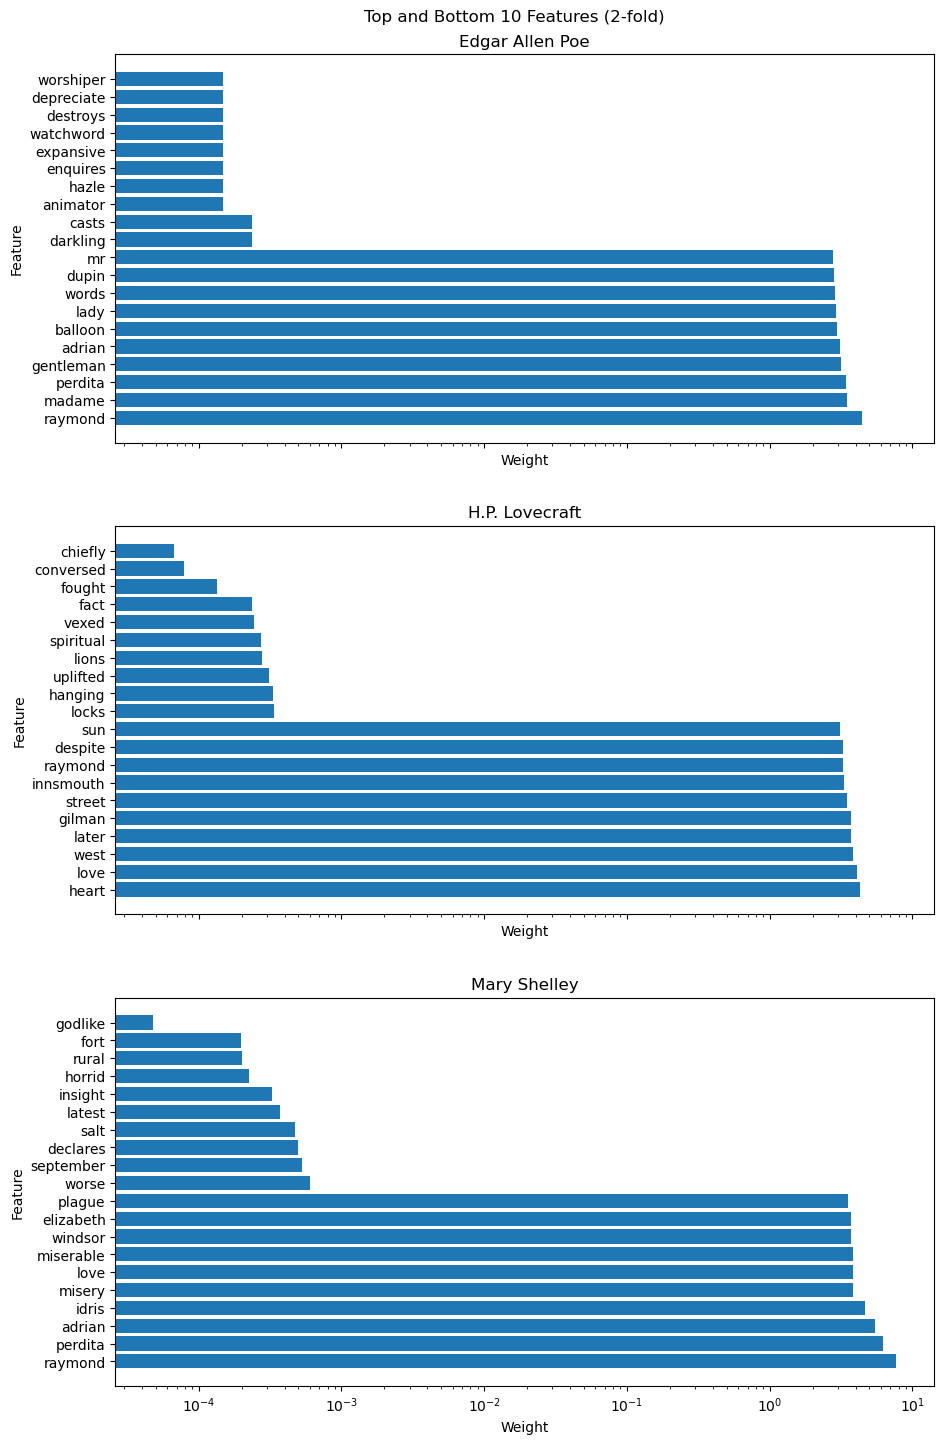

In [180]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3, figsize=(10,15), sharex=True)
fig.tight_layout(pad=5.0)
fig.suptitle("Top and Bottom 10 Features (2-fold)")
ax[0].barh(list(fold2df_eap["feature"]), list(fold2df_eap["EAP"]))
ax[0].set_title('Edgar Allen Poe')
ax[0].set_xlabel('Weight')
ax[0].set_ylabel('Feature')
ax[0].set_xscale('log')
ax[1].barh(list(fold2df_hpl["feature"]), list(fold2df_hpl["HPL"]))
ax[1].set_title('H.P. Lovecraft')
ax[1].set_xlabel('Weight')
ax[1].set_ylabel('Feature')
ax[1].set_xscale('log')
ax[2].barh(list(fold2df_mws["feature"]), list(fold2df_mws["MWS"]))
ax[2].set_title('Mary Shelley')
ax[2].set_xlabel('Weight')
ax[2].set_ylabel('Feature')
ax[2].set_xscale('log')


In [199]:
fold10df = pd.DataFrame(coef_dict['10-foldCV']['EAP'], columns=["feature", "EAP"])
fold10df["HPL"] = fold10df["feature"].map(dict(coef_dict['10-foldCV']['HPL']))
fold10df["MWS"] = fold10df["feature"].map(dict(coef_dict['10-foldCV']['MWS']))
fold10df = fold10df.set_index("feature")
fold10df.head()

,EAP,HPL,MWS
feature,,,
raymond,4.434277,3.288351,7.722628
madame,3.500283,2.165732,1.334551
perdita,3.436178,2.823615,6.259793
gentleman,3.144147,1.837098,1.307049
adrian,3.124130,2.322177,5.446307


In [183]:
fold10df_eap = pd.concat(
    [
        fold10df.sort_values(by="EAP")[:10], 
        fold10df.sort_values(by="EAP", ascending=False)[:10],
    ])
fold10df_eap = fold10df_eap.sort_values(by="EAP", ascending=False)
fold10df_eap = fold10df_eap.reset_index()
fold10df_hpl = pd.concat(
    [
        fold10df.sort_values(by="HPL")[:10], 
        fold10df.sort_values(by="HPL", ascending=False)[:10],
    ])
fold10df_hpl = fold10df_hpl.sort_values(by="HPL", ascending=False)
fold10df_hpl = fold10df_hpl.reset_index()
fold10df_mws = pd.concat(
    [
        fold10df.sort_values(by="MWS")[:10], 
        fold10df.sort_values(by="MWS", ascending=False)[:10],
    ])
fold10df_mws = fold10df_mws.sort_values(by="MWS", ascending=False)
fold10df_mws = fold10df_mws.reset_index()

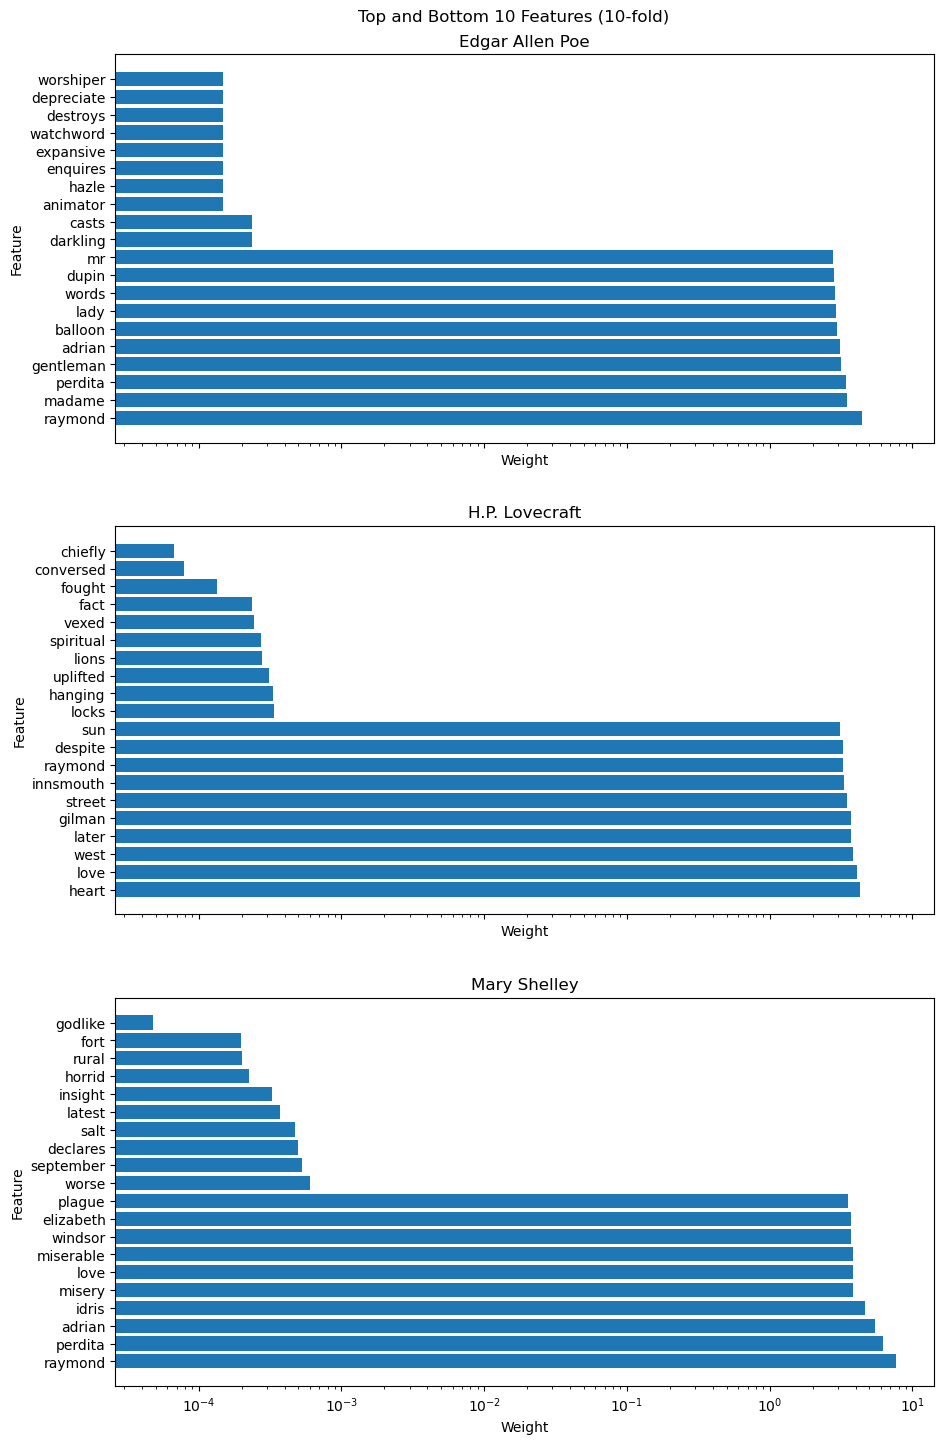

In [57]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3, figsize=(10,15), sharex=True)
fig.tight_layout(pad=5.0)
fig.suptitle("Top and Bottom 10 Features (10-fold)")
ax[0].barh(list(fold10df_eap["feature"]), list(fold10df_eap["EAP"]))
ax[0].set_title('Edgar Allen Poe')
ax[0].set_xlabel('Weight')
ax[0].set_ylabel('Feature')
ax[0].set_xscale('log')
ax[1].barh(list(fold10df_hpl["feature"]), list(fold10df_hpl["HPL"]))
ax[1].set_title('H.P. Lovecraft')
ax[1].set_xlabel('Weight')
ax[1].set_ylabel('Feature')
ax[1].set_xscale('log')
ax[2].barh(list(fold10df_mws["feature"]), list(fold10df_mws["MWS"]))
ax[2].set_title('Mary Shelley')
ax[2].set_xlabel('Weight')
ax[2].set_ylabel('Feature')
ax[2].set_xscale('log')


In [200]:
fold20df = pd.DataFrame(coef_dict['20-foldCV']['EAP'], columns=["feature", "EAP"])
fold20df["HPL"] = fold20df["feature"].map(dict(coef_dict['20-foldCV']['HPL']))
fold20df["MWS"] = fold20df["feature"].map(dict(coef_dict['20-foldCV']['MWS']))
fold20df = fold20df.set_index("feature")
fold20df.head()

,EAP,HPL,MWS
feature,,,
raymond,8.800133,6.583052,15.383186
perdita,6.817252,5.651567,12.468819
madame,6.288044,3.954476,2.333569
adrian,6.064149,4.426380,10.490530
gentleman,5.515557,3.231736,2.283821


In [185]:
fold20df_eap = pd.concat(
    [
        fold20df.sort_values(by="EAP")[:10], 
        fold20df.sort_values(by="EAP", ascending=False)[:10],
    ])
fold20df_eap = fold20df_eap.sort_values(by="EAP", ascending=False)
fold20df_eap = fold20df_eap.reset_index()
fold20df_hpl = pd.concat(
    [
        fold20df.sort_values(by="HPL")[:10], 
        fold20df.sort_values(by="HPL", ascending=False)[:10],
    ])
fold20df_hpl = fold20df_hpl.sort_values(by="HPL", ascending=False)
fold20df_hpl = fold20df_hpl.reset_index()
fold20df_mws = pd.concat(
    [
        fold20df.sort_values(by="MWS")[:10], 
        fold20df.sort_values(by="MWS", ascending=False)[:10],
    ])
fold20df_mws = fold20df_mws.sort_values(by="MWS", ascending=False)
fold20df_mws = fold20df_mws.reset_index()

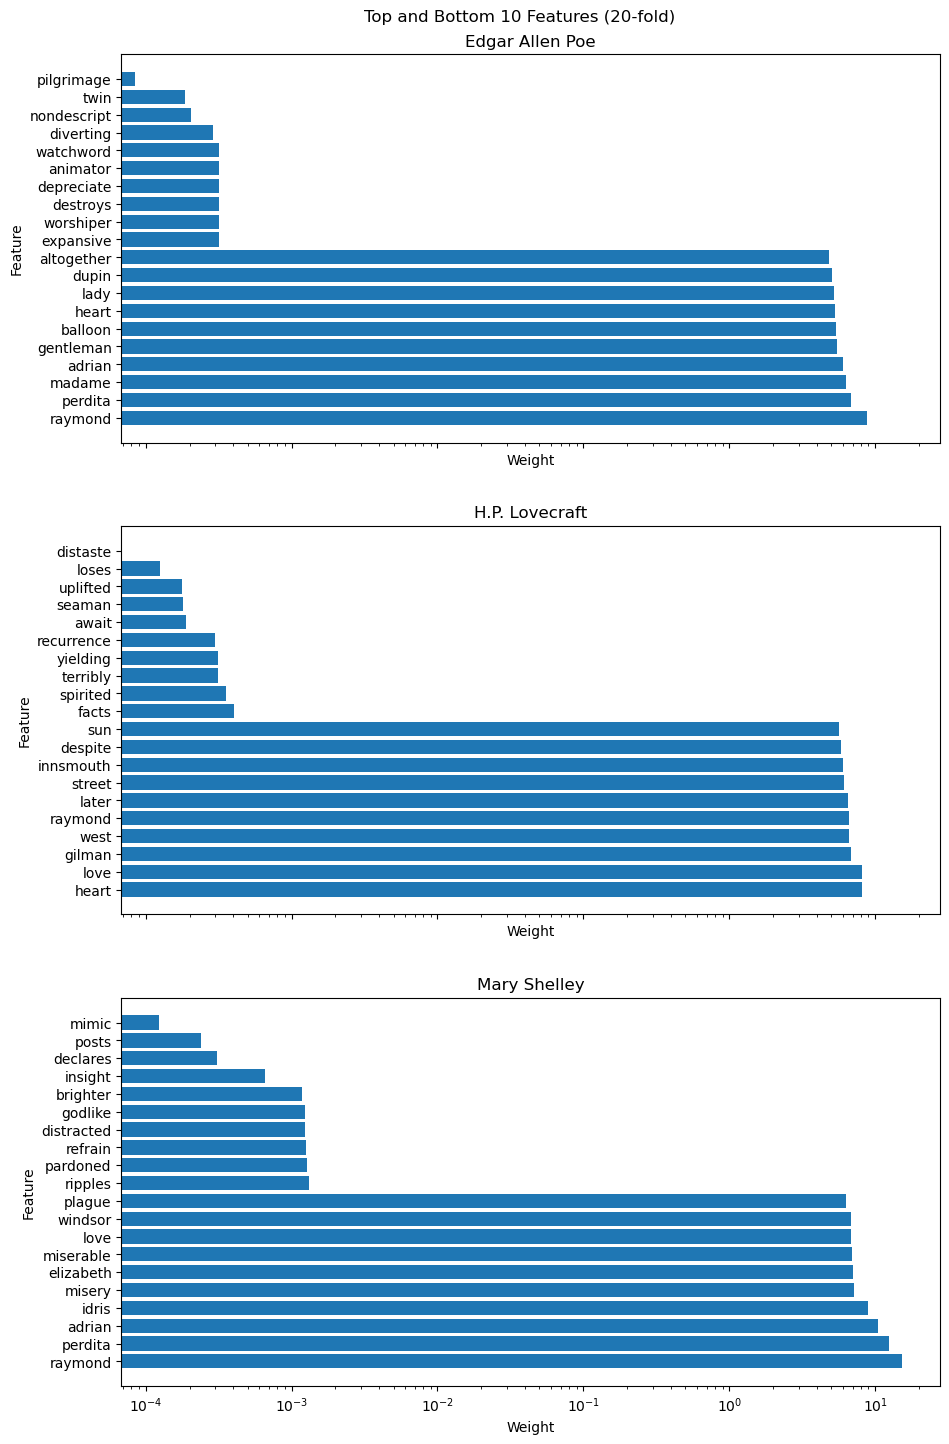

In [58]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3, figsize=(10,15), sharex=True)
fig.tight_layout(pad=5.0)
fig.suptitle("Top and Bottom 10 Features (20-fold)")
ax[0].barh(list(fold20df_eap["feature"]), list(fold20df_eap["EAP"]))
ax[0].set_title('Edgar Allen Poe')
ax[0].set_xlabel('Weight')
ax[0].set_ylabel('Feature')
ax[0].set_xscale('log')
ax[1].barh(list(fold20df_hpl["feature"]), list(fold20df_hpl["HPL"]))
ax[1].set_title('H.P. Lovecraft')
ax[1].set_xlabel('Weight')
ax[1].set_ylabel('Feature')
ax[1].set_xscale('log')
ax[2].barh(list(fold20df_mws["feature"]), list(fold20df_mws["MWS"]))
ax[2].set_title('Mary Shelley')
ax[2].set_xlabel('Weight')
ax[2].set_ylabel('Feature')
ax[2].set_xscale('log')


In [201]:
fold2df = fold2df.reset_index()
fold10df = fold10df.reset_index()
fold20df = fold20df.reset_index()

# All the weights of the added features

In [202]:
print("2-fold:")
count2 = fold2df[fold2df["feature"].isin(["noun_count","adj_count","verb_count"])].set_index("feature")
count10 = fold10df[fold10df["feature"].isin(["noun_count","adj_count","verb_count"])].set_index("feature")
count20 = fold20df[fold20df["feature"].isin(["noun_count","adj_count","verb_count"])].set_index("feature")
print(count2)
print("\n10-fold:")
print(count10)
print("\n20-fold:")
print(count20)

2-fold:
                 EAP       HPL       MWS
feature                                 
verb_count  0.749409  0.202503  0.546906
noun_count  0.547524  0.051992  0.495532
adj_count   0.189270  0.166192  0.023078

10-fold:
                 EAP       HPL       MWS
feature                                 
verb_count  0.749409  0.202503  0.546906
noun_count  0.547524  0.051992  0.495532
adj_count   0.189270  0.166192  0.023078

20-fold:
                 EAP       HPL       MWS
feature                                 
verb_count  0.762928  0.330903  0.432025
noun_count  0.363772  0.003455  0.360317
adj_count   0.156020  0.310727  0.154708


Text(87.59722222222221, 0.5, 'Feature')

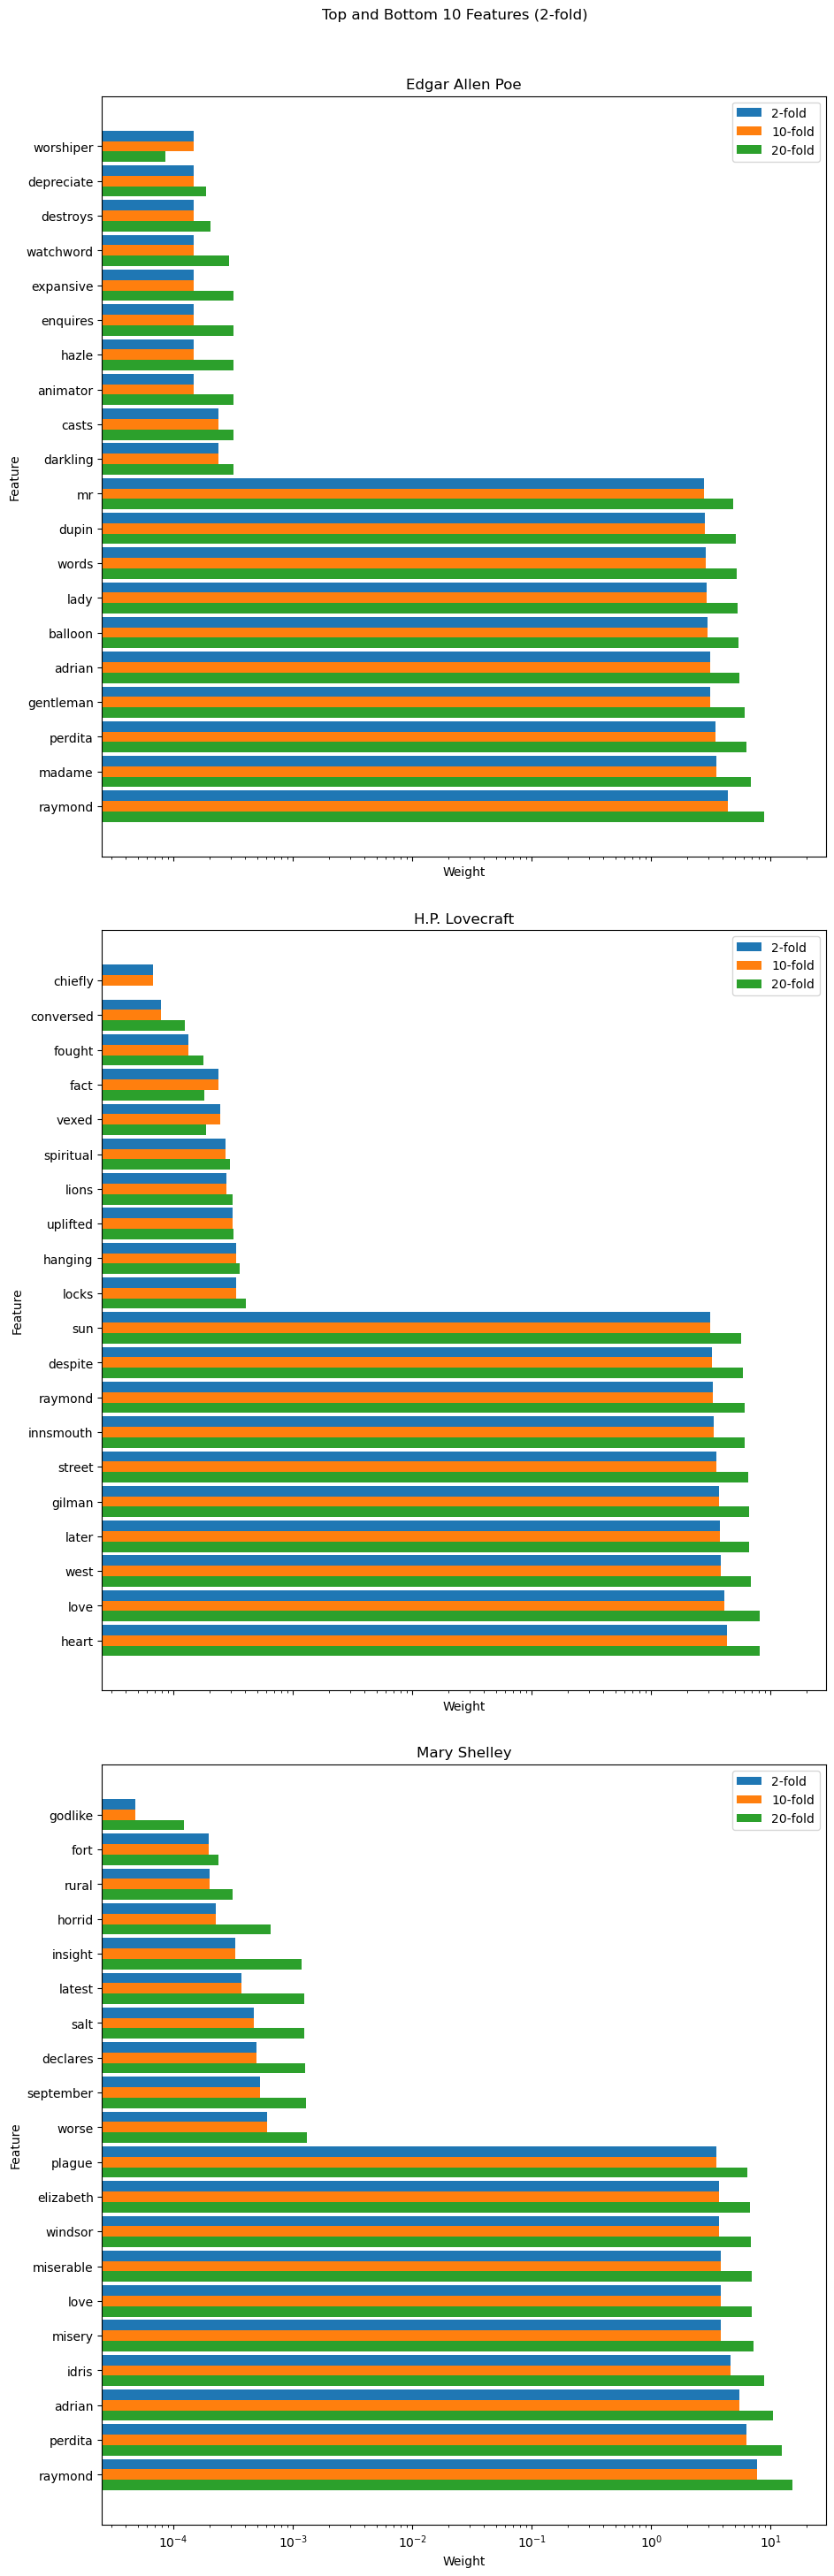

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3, figsize=(10,30), sharex=True)
fig.suptitle("Top and Bottom 10 Features (2-fold)")
fig.tight_layout(pad=5.0)
gfeat=np.arange(len(list(fold2df_eap["feature"])))
gfeat_w = 0.3
ax[0].barh(gfeat+gfeat_w, list(fold2df_eap["EAP"]), height=gfeat_w, log=True, label="2-fold")
ax[0].barh(gfeat, list(fold10df_eap["EAP"]), height=gfeat_w, log=True, label="10-fold")
ax[0].barh(gfeat-gfeat_w, list(fold20df_eap["EAP"]), height=gfeat_w, log=True, label="20-fold")
ax[0].set_yticks(gfeat, labels=list(fold2df_eap["feature"]))
ax[0].legend()
ax[0].set_title('Edgar Allen Poe')
ax[0].set_xlabel('Weight')
ax[0].set_ylabel('Feature')
ax[1].barh(gfeat+gfeat_w, list(fold2df_hpl["HPL"]), height=gfeat_w, log=True, label="2-fold")
ax[1].barh(gfeat, list(fold10df_hpl["HPL"]), height=gfeat_w, log=True, label="10-fold")
ax[1].barh(gfeat-gfeat_w, list(fold20df_hpl["HPL"]), height=gfeat_w, log=True, label="20-fold")
ax[1].set_yticks(gfeat, labels=list(fold2df_hpl["feature"]))
ax[1].legend()
ax[1].set_title('H.P. Lovecraft')
ax[1].set_xlabel('Weight')
ax[1].set_ylabel('Feature')
ax[2].barh(gfeat+gfeat_w, list(fold2df_mws["MWS"]), height=gfeat_w, log=True, label="2-fold")
ax[2].barh(gfeat, list(fold10df_mws["MWS"]), height=gfeat_w, log=True, label="10-fold")
ax[2].barh(gfeat-gfeat_w, list(fold20df_mws["MWS"]), height=gfeat_w, log=True, label="20-fold")
ax[2].set_yticks(gfeat, labels=list(fold2df_mws["feature"]))
ax[2].legend()
ax[2].set_title('Mary Shelley')
ax[2].set_xlabel('Weight')
ax[2].set_ylabel('Feature')


### Classification Report

This is the classification report after cross-validation/hyperparameter tuning.

In [206]:
# print("Old model:")
# print(classification_report(y_test, preds_original))

print("New model (with 3 added features):")
for e in preds:
    print(classification_report(y_test, e))

New model (with 3 added features):
              precision    recall  f1-score   support

         EAP       0.79      0.79      0.79      2587
         HPL       0.78      0.80      0.79      1852
         MWS       0.80      0.78      0.79      2023

    accuracy                           0.79      6462
   macro avg       0.79      0.79      0.79      6462
weighted avg       0.79      0.79      0.79      6462

              precision    recall  f1-score   support

         EAP       0.79      0.79      0.79      2587
         HPL       0.78      0.80      0.79      1852
         MWS       0.80      0.78      0.79      2023

    accuracy                           0.79      6462
   macro avg       0.79      0.79      0.79      6462
weighted avg       0.79      0.79      0.79      6462

              precision    recall  f1-score   support

         EAP       0.79      0.79      0.79      2587
         HPL       0.79      0.79      0.79      1852
         MWS       0.79      0.79      0

# Final Predictions

Here, the final results are gathered with the probability score for each author
for each sentence.

In [ ]:
submission = pd.read_csv('./input/test.csv')

#preprocessing
submission = processing(submission)
predictions = clf[0].predict_proba(submission)

preds = pd.DataFrame(data=predictions, columns = clf[0].best_estimator_.named_steps['features'].classes_)

result = pd.concat([submission[['id']], preds], axis=1)
result.set_index('id', inplace = True)
print("New:")
print(result.head())

# Discussion

Looking at the classification report, we can see that the new model performed
slightly worse than the old model.  The reason for this is unclear since I would
have thought that the addition of the new features
would have increased the precision and recall.

One item of note is that the model
performance between the old model and the new model is pretty small.  Without
some statistical analysis, we don't really know if the difference is
statistically significant.  Given this knowledge, we really cannot conclude
anything and any analysis of this data without a deeper statistical analysis
would be anecdotal at best.

Yet another dimension to all of this is the differences in performance from the
initial fit and the model with tuned hyperparameters.  It seems that the
hyperparameter tuning I chose did not make much of a difference to the final
results.  All of this requires further investigation and analysis.